In [1]:
from models.binary import BinaryMemeClassifier
from models.multi import ImagenetTransferLearning

import mlflow
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder


Seed set to 42


In [ ]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")
binary_model = BinaryMemeClassifier.load_from_checkpoint("/home/hsdslab/murgi/meme-research-2024/src/models/best/binary_densenet121epoch=01-val_loss=0.00.ckpt")
template_model = ImagenetTransferLearning.load_from_checkpoint("/home/hsdslab/murgi/meme-research-2024/src/models/best/multi_densenet121epoch=09-val_loss=0.00.ckpt")

In [2]:
os.chdir('/home/hsdslab/murgi/meme-research-2024')
reddit_df = pd.read_parquet('./data/sm/reddit.parquet')
twitter_df = pd.read_parquet('./data/sm/twitter.parquet')
fb_df = pd.read_parquet('./data/sm/facebook.parquet')

In [30]:
fb_df=fb_df.rename(columns={"filepath":"path"})
fb_df.loc[:,"path"] =  fb_df.loc[:,"path"].apply(lambda x: x.replace("D:\\Murgi\\Facebook2023\\Facebook2023", "/home/hsdslab/murgi/Facebook2023"))
fb_df.loc[:,"path"] =  fb_df.loc[:,"path"].apply(lambda x: x.replace("\\","/"))

twitter_df=twitter_df.rename(columns={"filepath":"path"})
twitter_df.loc[:,"path"] =  twitter_df.loc[:,"path"].apply(lambda x: x.replace("D:\\Murgi\\Twitter2023","/home/hsdslab/murgi/Twitter2023"))
twitter_df.loc[:,"path"] =  twitter_df.loc[:,"path"].apply(lambda x: x.replace("\\","/"))

reddit_dir = '/home/hsdslab/murgi/Memes2022Final2' 
files = os.listdir(reddit_dir)
id_to_files = {os.path.splitext(file)[0]:file for file in files}

reddit_df['path'] = reddit_df['id'].apply(lambda x: os.path.join(reddit_dir,id_to_files[x]) if x in id_to_files else None)



import random

random.seed(123)

all_reddit_memes = reddit_df['path'].tolist()
sample_reddit_memes = random.sample(all_reddit_memes, 1000)
rest_reddit_memes = list(set(all_reddit_memes) - set(sample_reddit_memes))

all_fb_memes = fb_df['path'].tolist()
sample_fb_memes = random.sample(all_fb_memes, 1000)
rest_fb_memes = list(set(all_reddit_memes) - set(sample_fb_memes))


all_twitter_memes = twitter_df['path'].tolist()
sample_twitter_memes = random.sample(all_twitter_memes, 1000)
rest_twitter_memes = list(set(all_twitter_memes) - set(sample_twitter_memes))

all_the_rest = rest_reddit_memes + rest_fb_memes + rest_twitter_memes
random.shuffle(all_the_rest)

X_paths = sample_reddit_memes + sample_fb_memes + sample_twitter_memes + all_the_rest

In [32]:
reddit_paths = reddit_df['path'].dropna().tolist()
test = reddit_paths[:100]

facebook_paths = fb_df['path'].dropna().tolist()

twitter_paths = twitter_df['path'].dropna().tolist()

In [48]:
len(twitter_paths)

174338

In [33]:
# import dataloader from pytorch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms
import pandas as pd
import torch

class SMDataset(Dataset):
    def __init__(self, paths:list):
        self.paths = paths
        self.transform =  transforms.Compose([
              transforms.Resize(size=(224,224)),
              transforms.ToTensor(),
              transforms.Normalize([0.5325, 0.4980, 0.4715],[0.3409, 0.3384, 0.3465])
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        try:
            img_path = self.paths[idx]
            img = Image.open(img_path).convert('RGB')
            img = self.transform(img)
            
        except Exception as e:
            print(f"Error reading image at index {idx}: {e}")
            return None, None
        
        return img, img_path


def my_collate_fn(batch):
    """ Filter out None samples """
    batch = [item for item in batch if item[0] is not None]
    if len(batch) == 0:
        return torch.Tensor(), torch.Tensor()  # Empty tensors if batch is fully invalid
    return torch.utils.data.dataloader.default_collate(batch)

sm_dataset = SMDataset(twitter_paths)
sm_dataloader = DataLoader(sm_dataset, batch_size=48, shuffle=False, collate_fn=my_collate_fn, num_workers=4)

In [34]:
import torch
from pytorch_lightning import Trainer
from model import CombinedMemeClassifier


combined_model = CombinedMemeClassifier(binary_model, template_model)

# Switch to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
combined_model = combined_model.to(device)


trainer = Trainer(accelerator='gpu')

predictions = trainer.predict(combined_model, sm_dataloader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/hsdslab/murgi/meme-research-2024/meme-research/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hsdslab/murgi/meme-research-2024/meme-research/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hsdslab/murgi/meme-research-2024/meme-research/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hsdslab/murgi/meme-research-2024/meme-research/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [35]:
# save predictions
import pickle

with open('twitter_predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)

## Collect and aggregate the inferences for the different SM platforms

In [36]:
with open('twitter_predictions.pkl', 'rb') as f:
    twitter_predictions = pickle.load(f)

with open('facebook_predictions.pkl', 'rb') as f:
    facebook_predictions = pickle.load(f)

with open('reddit_predictions.pkl', 'rb') as f:
    reddit_predictions = pickle.load(f)

In [43]:
twitter_predictions[0]

{'meme_likelihood': tensor([9.9991e-01, 1.8779e-03, 8.8735e-10, 9.0720e-01, 3.7657e-06, 9.8823e-01,
         4.2393e-06, 1.0000e+00, 9.7299e-04, 2.9113e-02, 7.9331e-01, 9.9999e-01,
         3.3677e-06, 1.5600e-01, 1.8646e-05, 2.7828e-06, 1.4271e-02, 1.3450e-06,
         1.0000e+00, 5.0464e-01, 4.3713e-02, 9.9981e-01, 9.9710e-01, 3.1279e-02,
         7.3895e-01, 9.9995e-01, 3.2668e-01, 9.9792e-01, 3.4669e-02, 2.1459e-06,
         9.9821e-01, 7.0676e-04, 2.7826e-05, 2.1237e-04, 1.8038e-01, 2.3673e-03,
         2.9715e-08, 7.2831e-07, 8.7542e-09, 6.9093e-01, 4.2372e-06, 9.9799e-01,
         3.4662e-07, 4.5290e-01, 1.4089e-09, 9.9995e-01, 9.9572e-01, 9.8800e-01]),
 'template_output': tensor([  52,   -1,   -1,  128,   -1, 1014,   -1,  914,   -1,   -1,  535,  438,
           -1,   -1,   -1,   -1,   -1,   -1,  125,  693,   -1,  538,  138,   -1,
          344,  125,   -1,  578,   -1,   -1,    6,   -1,   -1,   -1,   -1,   -1,
           -1,   -1,   -1,  827,   -1,  344,   -1,   -1,   -1,  130, 

In [53]:
def create_pred_df(predictions:list):
    preds = [batch['template_output'].cpu().numpy() for batch in predictions]
    preds = [item for sublist in preds for item in sublist]
    paths = [batch['paths'] for batch in predictions]
    paths = [item for sublist in paths for item in sublist]
    id = [os.path.splitext(os.path.basename(path))[0] for path in paths]
    df = pd.DataFrame({"id":id, "predicted_template":preds, "path":paths})
    return df

reddit_pred_df = create_pred_df(reddit_predictions)
reddit_pred_df['source'] = 'reddit'
facebook_pred_df = create_pred_df(facebook_predictions)
facebook_pred_df['source'] = 'facebook'
twitter_pred_df = create_pred_df(twitter_predictions)
twitter_pred_df['source'] = 'twitter'

all_sm_df = pd.concat([reddit_pred_df, facebook_pred_df, twitter_pred_df])
all_sm_df

,id,predicted_template,path,source
0,2021.11.14_0,-1,/home/hsdslab/murgi/Memes2022Final2/2021.11.14...,reddit
1,2021.11.14_103,1026,/home/hsdslab/murgi/Memes2022Final2/2021.11.14...,reddit
2,2021.11.14_10,-1,/home/hsdslab/murgi/Memes2022Final2/2021.11.14...,reddit
3,2021.11.14_100,-1,/home/hsdslab/murgi/Memes2022Final2/2021.11.14...,reddit
4,2021.11.14_108,126,/home/hsdslab/murgi/Memes2022Final2/2021.11.14...,reddit
...,...,...,...,...
174333,2020_6-43958,-1,/home/hsdslab/murgi/Twitter2023/2020_6-43958.jpg,twitter
174334,2020_6-43959,912,/home/hsdslab/murgi/Twitter2023/2020_6-43959.jpg,twitter
174335,2020_6-43960,-1,/home/hsdslab/murgi/Twitter2023/2020_6-43960.jpg,twitter
174336,2020_6-43961,608,/home/hsdslab/murgi/Twitter2023/2020_6-43961.jpg,twitter


In [56]:
meme_df = pd.read_parquet('/home/hsdslab/murgi/meme-research-2024/data/processed/gpu_server_meme_entries.parquet')
meme_df

labelencoder = LabelEncoder()
meme_df['template_id'] = labelencoder.fit_transform(meme_df['template_name'])

all_sm_df['predicted_template_name'] = all_sm_df['predicted_template'].apply(lambda x: labelencoder.inverse_transform([x])[0] if x != -1 else "templateless")
all_sm_df

,id,predicted_template,path,source,predicted_template_name
0,2021.11.14_0,-1,/home/hsdslab/murgi/Memes2022Final2/2021.11.14...,reddit,templateless
1,2021.11.14_103,1026,/home/hsdslab/murgi/Memes2022Final2/2021.11.14...,reddit,trust-nobody-not-even-yourself
2,2021.11.14_10,-1,/home/hsdslab/murgi/Memes2022Final2/2021.11.14...,reddit,templateless
3,2021.11.14_100,-1,/home/hsdslab/murgi/Memes2022Final2/2021.11.14...,reddit,templateless
4,2021.11.14_108,126,/home/hsdslab/murgi/Memes2022Final2/2021.11.14...,reddit,black-guy-crying-and-black-guy-laughing
...,...,...,...,...,...
174333,2020_6-43958,-1,/home/hsdslab/murgi/Twitter2023/2020_6-43958.jpg,twitter,templateless
174334,2020_6-43959,912,/home/hsdslab/murgi/Twitter2023/2020_6-43959.jpg,twitter,spongebob-vs-squidward-alarm-clocks
174335,2020_6-43960,-1,/home/hsdslab/murgi/Twitter2023/2020_6-43960.jpg,twitter,templateless
174336,2020_6-43961,608,/home/hsdslab/murgi/Twitter2023/2020_6-43961.jpg,twitter,megamind-no-bitches


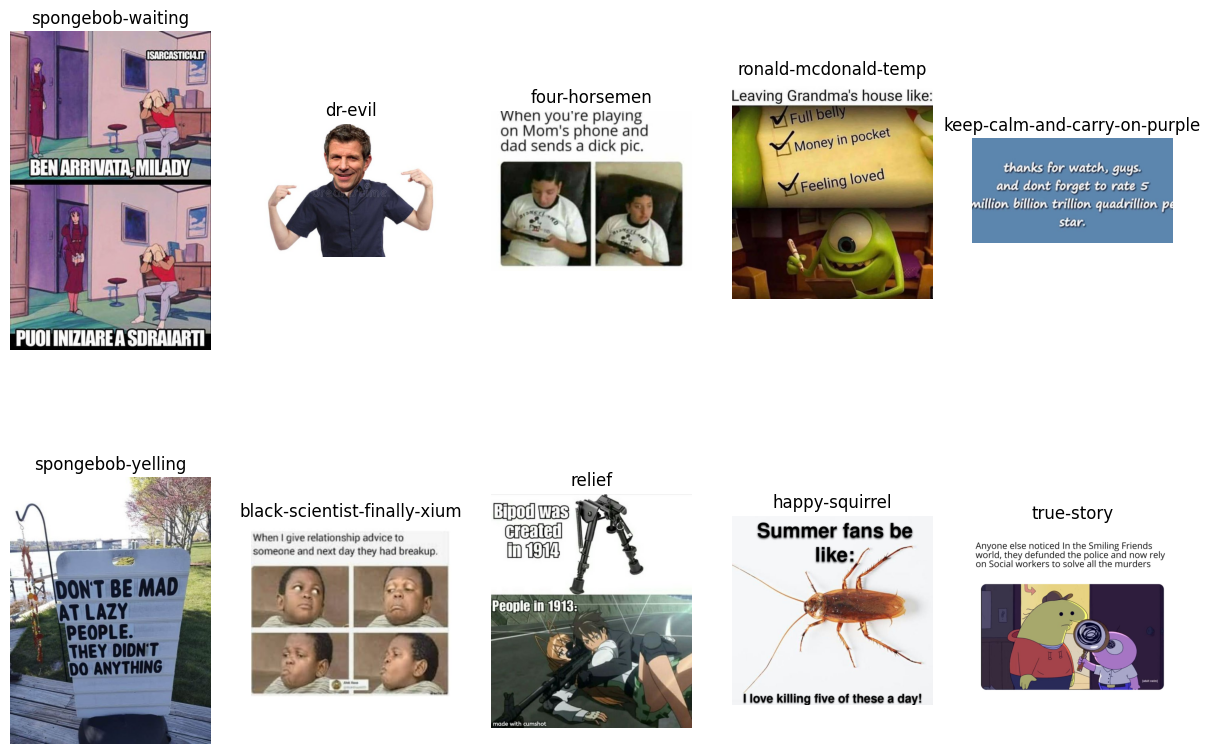

In [101]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


# create function that plots 10 random images from the dataframe with their predicted template as title
def plot_images(df:pd.DataFrame):
    df = df[df['predicted_template'] != -1]
    fig, ax = plt.subplots(2,5, figsize=(15,10))
    for i in range(2):
        for j in range(5):
            random_index = np.random.randint(0,df.shape[0])
            img_path = df.iloc[random_index]['path']
            img = mpimg.imread(img_path)
            ax[i,j].imshow(img)
            ax[i,j].set_title(df.iloc[random_index]['predicted_template_name'])
            ax[i,j].axis('off')
    plt.show()

plot_images(all_sm_df)

In [102]:
all_sm_df.to_parquet("/home/hsdslab/murgi/meme-research-2024/data/sm/social_media_preds_with_outliers_CNN.parquet")